# Airbnb price prediction

## Seasonality explotarion from RevPAR open data
We start exploring the seasonality from open available data. We will analyze the effect of:
* Daily RevPAR from  Airbnb listings
* National holidays in Peru
* Day of the week
* Assumptions on bridge days (long weekends)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
#ipympl enables 'matplotlib widget' for interactive widgets framework
%matplotlib widget

In [2]:
# Import Airbnb RevPAR data of Chaclacayo - Peru
df_revPAR = pd.read_excel('seasonality.xlsx', sheet_name='RevPAR-Chaclacayo')
df_revPAR['Date'] = pd.to_datetime(df_revPAR['Date'])
df_revPAR['CW'] = df_revPAR['Date'].dt.isocalendar().week

# Normalize numeric values
df_revPAR['n_RevPAR']=(df_revPAR['RevPAR']-df_revPAR['RevPAR'].min())\
    /(df_revPAR['RevPAR'].max()-df_revPAR['RevPAR'].min())

# Find weekdays and weekends
for index, row in df_revPAR.iterrows():
    if (row.Day == 'Saturday') or (row.Day == 'Sunday'):
        df_revPAR.loc[index, 'CW_alt'] = str(row.CW) + '_w'
    else:
        df_revPAR.loc[index, 'CW_alt'] = str(row.CW) + '_d'
df_revPAR.head()

,Date,RevPAR,Day,CW,n_RevPAR,CW_alt
0,2021-09-01,1034,Wednesday,35,0.834881,35_d
1,2021-09-02,678,Thursday,35,0.467492,35_d
2,2021-09-03,838,Friday,35,0.632611,35_d
3,2021-09-04,884,Saturday,35,0.680083,35_w
4,2021-09-05,834,Sunday,35,0.628483,35_w


In [3]:
# Import National holidays in Peru
df_holidays = pd.read_excel('seasonality.xlsx', sheet_name='Holidays')
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df_holidays['CW'] = df_holidays['Date'].dt.isocalendar().week
df_holidays['Day']= df_holidays['Date'].dt.day_name()

# Add bridge days:
# * Friday after a holiday in Thursday
for index, row in df_holidays.iterrows():
    if row['Day']=='Thursday' and row['Date'] + pd.Timedelta(days=1) not in df_holidays['Date'].values:
        temp = pd.DataFrame({'Date': [row['Date'] + pd.Timedelta(days=1)], 'Holiday': ['bridge day']})
        temp['CW'] = row['CW']
        temp['Day'] = 'Friday'
        df_holidays = pd.concat([df_holidays, temp], axis=0)
        df_holidays.sort_values(by='Date', inplace=True)
        df_holidays.reset_index(drop=True, inplace=True)
        del temp

df_holidays.head(20)

,Date,Holiday,Importance,CW,Day
0,2021-08-30,Santa Rosa de Lima,0.00,35,Monday
1,2021-10-08,Combate Naval de Angamos,0.00,40,Friday
2,2021-11-01,Día de todos los Santos,0.00,44,Monday
3,2021-12-08,Inmaculada Concepción,0.00,49,Wednesday
4,2021-12-25,Navidad,0.00,51,Saturday
5,2022-01-01,Año Nuevo,0.00,52,Saturday
6,2022-04-14,Jueves Santo,0.00,15,Thursday
7,2022-04-15,Viernes Santo,0.00,15,Friday
8,2022-04-17,Domingo de Resurrección,0.00,15,Sunday
9,2022-05-01,Día del Trabajo,0.00,17,Sunday


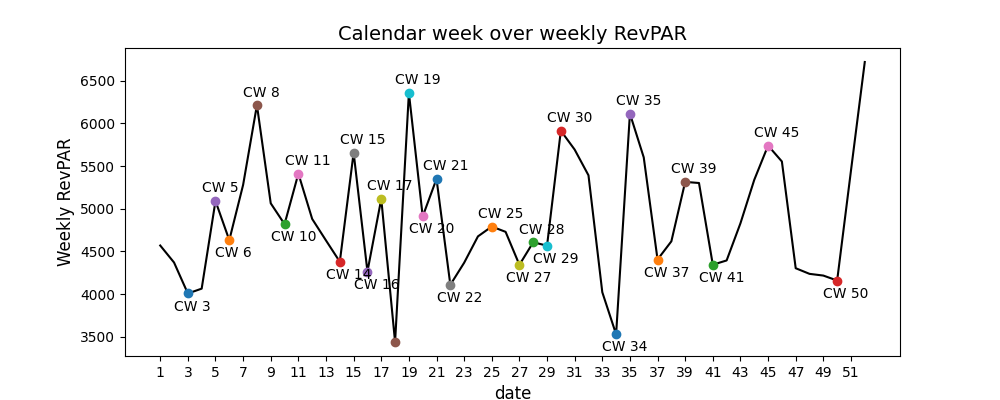

In [4]:
# Calculate aggregated RevPAR per Calendar Week
cw_df_revPAR = df_revPAR.groupby(df_revPAR.CW)['RevPAR'].sum()

dates = np.array(cw_df_revPAR.index.tolist())
returns = np.array(cw_df_revPAR.values.tolist())

# Calculate the minimas and the maximas
minimas = (np.diff(np.sign(np.diff(returns))) > 0).nonzero()[0] + 1
maximas = (np.diff(np.sign(np.diff(returns))) < 0).nonzero()[0] + 1

# We plot RevPAR
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(cw_df_revPAR, color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 12)
ax.set_ylabel("Weekly RevPAR", color="black", fontsize=12)

for minima in minimas:
    ax.plot(minima+1, cw_df_revPAR.iloc[minima], marker="o")
    ax.annotate("CW " + str(minima+1),xy=(minima,cw_df_revPAR.iloc[minima]-200))
    
for maxima in maximas:
    ax.plot(maxima+1, cw_df_revPAR.iloc[maxima], marker="o")
    ax.annotate("CW " + str(maxima+1),xy=(maxima,cw_df_revPAR.iloc[maxima]+100))

temp = range(1,53,2);plt.xticks(temp);del temp
plt.title('Calendar week over weekly RevPAR', fontsize = 14)

mplcursors.cursor(hover=True) # Interacive

plt.show()

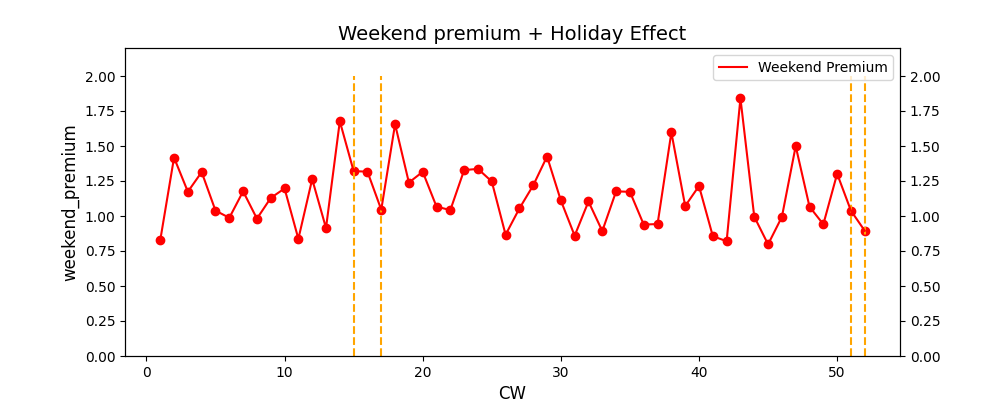

In [5]:
# Find weekend premium
wp_df_revPAR = df_revPAR.groupby(df_revPAR.CW_alt)['RevPAR'].mean()

df_prem = pd.DataFrame(columns=['CW', 'weekend_premium'])

for i in df_revPAR.CW.unique():
    prem = wp_df_revPAR.loc[str(i)+'_w']/wp_df_revPAR.loc[str(i)+'_d']
    df_prem.loc[i,'CW'] = i
    df_prem.loc[i,'weekend_premium'] = prem

df_prem.sort_index(inplace=True)
df_prem.drop(columns = ['CW'], inplace=True)

# We plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(df_prem.index, df_prem['weekend_premium'], color="red", label="Weekend Premium")
ax.set_ylim([0, 2.2])
ax2=ax.twinx()
ax2.plot(df_prem.index, df_prem['weekend_premium'], color="red", label="Weekend Premium")
ax2.set_ylim([0, 2.2])

# Holidays
ax.vlines(x=df_holidays[(df_holidays.Day == 'Saturday') & (df_holidays.Date < '2022-10')]['Date'].dt.isocalendar().week, ymin=0, ymax=2, color="orange", linestyles='dashed')
ax.vlines(x=df_holidays[(df_holidays.Day == 'Sunday') & (df_holidays.Date < '2022-10')]['Date'].dt.isocalendar().week, ymin=0, ymax=2, color="orange", linestyles='dashed')

ax.set_xlabel("CW", fontsize = 12)
ax.set_ylabel("weekend_premium", color="black", fontsize=12)

plt.title('Weekend premium + Holiday Effect', fontsize = 14)
plt.legend()

mplcursors.cursor(ax, hover=True) # Interacive

plt.show()

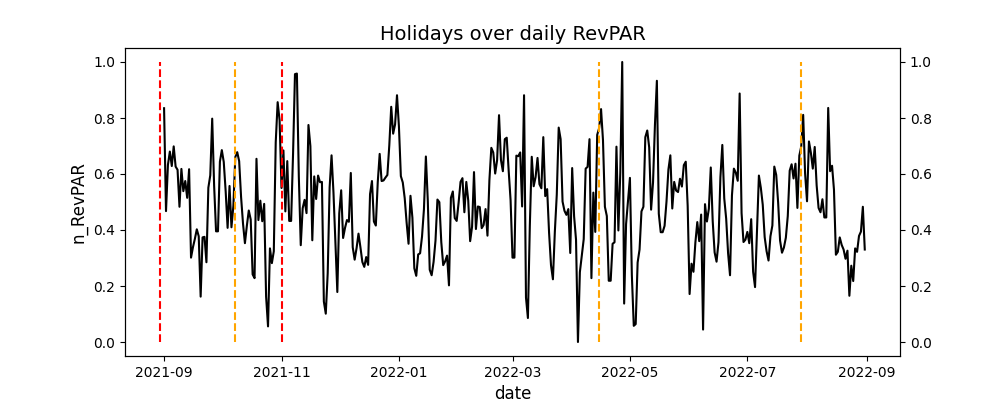

In [6]:
# We plot RevPAR & holidays
fig, ax = plt.subplots(figsize=(10, 4))

# RevPAR
ax.plot(df_revPAR['Date'], df_revPAR['n_RevPAR'], color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 12)
ax.set_ylabel("n_RevPAR", color="black", fontsize=12)
# Holidays
ax2=ax.twinx()
ax2.vlines(x=df_holidays[(df_holidays.Day == 'Monday') & (df_holidays.Date < '2022-10')]['Date'], ymin=0, ymax=1, color="r", linestyles='dashed')
ax2.vlines(x=df_holidays[(df_holidays.Day == 'Friday') & (df_holidays.Date < '2022-10')]['Date'], ymin=0, ymax=1, color="orange", linestyles='dashed')
ax2.vlines(x=df_holidays[(df_holidays.Day == 'Thrusday') & (df_holidays.Date < '2022-10')]['Date'], ymin=0, ymax=1, color="lime", linestyles='dashed')

plt.title('Holidays over daily RevPAR', fontsize = 14)
plt.show()

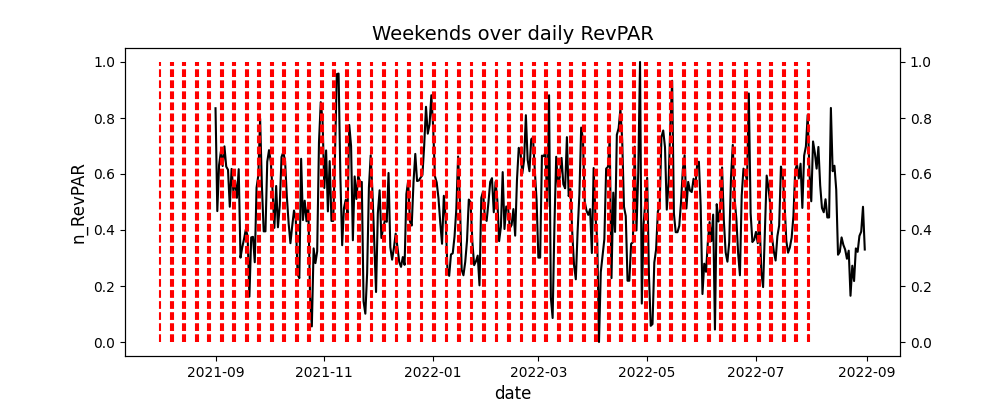

In [7]:
# Now we analyze the effect of weekends
weekends = pd.bdate_range(start="2021-08-01", end="2022-07-31", freq="C", weekmask="Sat Sun")

# We plot RevPAR & holidays
fig, ax = plt.subplots(figsize=(10, 4))

# RevPAR
ax.plot(df_revPAR['Date'], df_revPAR['n_RevPAR'], color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 12)
ax.set_ylabel("n_RevPAR", color="black", fontsize=12)
# Holidays
ax2=ax.twinx()
ax2.vlines(x=weekends, ymin=0, ymax=1, color="r", linestyles='dashed')

plt.title('Weekends over daily RevPAR', fontsize = 14)
plt.show()

## Observations
* Mondays & Fridays as holiday indicates a long weekend with high RevPAR
* Friday as bridge day don't indicate high RevPAR
* Thrusday as holiday indicates a long weekend and high RevPAR only during the Holy Week and Independence day (due to two days holidays in a row). Also, potentially this could apply for New Year's eve and Christmas.
* Weekends have a relative high RevPAR to their respective months
* Highest RevPAR is found in February & March, during the summer holidays; also then in Holy Week and school holidays. July is an exceptional month, by the end of December. Around October until the mid Nov RevPAR is also up.
* All other CW are either average or below average.
* It is not possible to identify any holiday effect
* Weekend premium is uncertain.
* The day before the holiday can be charged with a premium.

## Data exploration specific data
Now, we explore our specific house data. We analyze:
* Income per stay (without cleaning fees)
* Booking time in advance

In [8]:
# Import DB
df = pd.read_excel('Guest_Chaclacayo.xlsx', sheet_name='Reservas')

In [9]:
# convert dates column to DateTime
df['R_Date'] = pd.to_datetime(df['R_Date'])
df['R_CheckIn'] = pd.to_datetime(df['R_CheckIn'])
df['R_CheckOut'] = pd.to_datetime(df['R_CheckOut'])

# Replace NaN in R_Extra
df['R_Extra'] = df['R_Extra'].fillna(0)
df['R_DNI'] = df['R_DNI'].fillna(0)

# Change to Int
df['R_NumGuests'] = df['R_NumGuests'].astype(np.int64)
df['R_DNI'] = df['R_DNI'].astype(np.int64)

# Calculate, how much time in advance the house is booked
df['Adv_booked'] = df['R_CheckIn'] - df['R_Date']

# Calculate, for how long is the house booked
df['Days_booked'] = df['R_CheckOut'] - df['R_CheckIn']

# Normalize numeric values
df['n_R_Income']=(df['R_Income']-df['R_Income'].min())/(df['R_Income'].max()-df['R_Income'].min())

# Adding calendar weeks. For simpl., we base them in the R_CheckIn date; even if they stay longer than a week.
df['CW'] = df['R_CheckIn'].dt.isocalendar().week

df.head()

,R_ID,R_Date,R_CheckIn,R_CheckOut,R_NumGuests,R_Shifted,R_Car,R_Pet,R_Income,R_Extra,R_Guest,R_DNI,R_Comments,Adv_booked,Days_booked,n_R_Income,CW
0,Chacla0001,2021-12-31,2021-12-31,2022-01-02,10,False,True,False,1775.0,0.0,Tommy Baldeon,0,NaN,0 days,2 days,0.184785,52
1,Chacla0002,2022-01-05,2022-01-05,2022-01-07,5,True,True,False,1086.0,0.0,augusto quispe,10323589,NaN,0 days,2 days,0.044259,1
2,Chacla0003,2022-01-07,2022-01-07,2022-01-09,6,False,True,False,1086.0,0.0,gebsabella campos,0,NaN,0 days,2 days,0.044259,1
3,Chacla0004,2022-01-07,2022-01-14,2022-01-16,8,False,True,False,869.0,0.0,NaN,0,NaN,7 days,2 days,0.000000,2
4,Chacla0005,2022-01-07,2022-01-18,2022-01-20,8,False,True,False,1032.0,0.0,NaN,0,NaN,11 days,2 days,0.033245,3


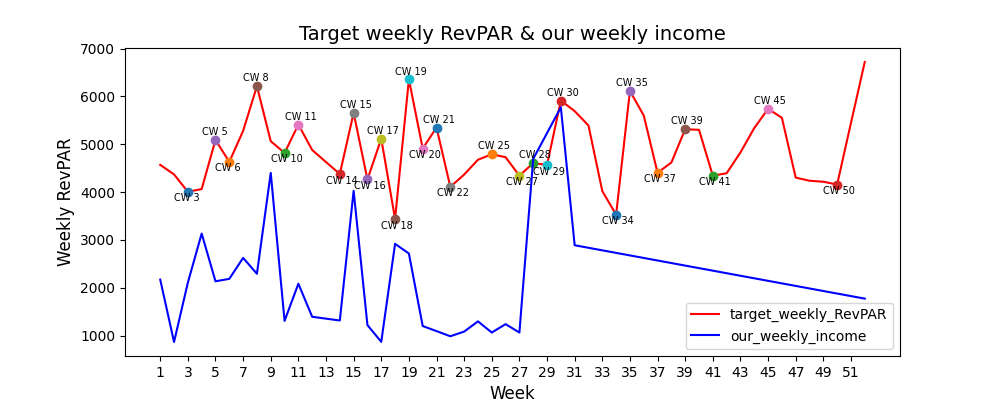

In [10]:
# We plot RevPAR
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(cw_df_revPAR, color="red", label="target_weekly_RevPAR")

for minima in minimas:
    ax.plot(minima+1, cw_df_revPAR.iloc[minima], marker="o")
    ax.annotate("CW " + str(minima+1),xy=(minima,cw_df_revPAR.iloc[minima]-200), fontsize=7)
    
for maxima in maximas:
    ax.plot(maxima+1, cw_df_revPAR.iloc[maxima], marker="o")
    ax.annotate("CW " + str(maxima+1),xy=(maxima,cw_df_revPAR.iloc[maxima]+100), fontsize=7)

# Calculate weekly income
cw_df = df.groupby(df.CW)['R_Income'].sum()

# We plot weekly income
ax.plot(cw_df, color="blue", label="our_weekly_income")

ax.set_xlabel("Week", fontsize = 12)
ax.set_ylabel("Weekly RevPAR", color="black", fontsize=12)

temp = range(1,53,2);plt.xticks(temp);del temp
plt.title('Target weekly RevPAR & our weekly income', fontsize = 14)
plt.legend()

mplcursors.cursor(hover=True) # Interacive

plt.show()

In [11]:
# Import Airbnb Booking Lead Time - BLT
df_BLT = pd.read_excel('seasonality.xlsx', sheet_name='BLT-Chaclacayo')
df_BLT.rename(columns={"Booking_Lead_Time (days)": "BLT_days"}, inplace=True)
df_BLT['btl_Month'] = pd.to_datetime(df_BLT['Month']).dt.month
df_BLT.sort_values('btl_Month', inplace=True)
df_BLT.head(12)

,Month,BLT_days,btl_Month
5,2022-01,15,1
6,2022-02,16,2
7,2022-03,11,3
8,2022-04,19,4
9,2022-05,14,5
10,2022-06,15,6
11,2022-07,26,7
0,2021-08,18,8
12,2022-08,13,8
1,2021-09,15,9


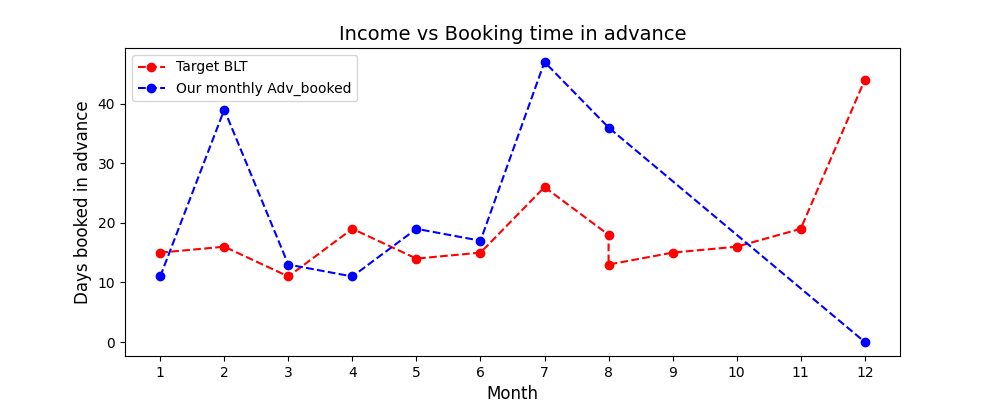

In [12]:
# We find the BLT per month
m_df = df.groupby(pd.DatetimeIndex(df['R_CheckIn']).month)['Adv_booked'].mean().dt.days

# We plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_BLT['btl_Month'], df_BLT['BLT_days'], 'o--', color="red", label="Target BLT")
ax.plot(m_df.index, m_df, 'o--', color="blue", label="Our monthly Adv_booked")

ax.set_xlabel("Month", fontsize = 12)
ax.set_ylabel("Days booked in advance", color="black", fontsize=12)

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.title('Income vs Booking time in advance', fontsize = 14)
plt.legend()

mplcursors.cursor(hover=True) # Interacive

plt.show()

## Observations
* Our income for Holy Week and Independence Day followed a similar peak to the target weekly RevPAR, but all other weeks differ.
* We need to increase our income for all other weeks than those holidays.
* Our accomodation is booked too soon for those main holidays. 